<h1 style="text-align:center">Advanced Statistical Inference</h1>
<h1 style="text-align:center">Bayesian Logistic Regression - Metropolis-Hastings</h1>



## 1. Aims
<div class="alert alert-info">
<ul> 
<li> To implement the MH algorithm.
<li> To use it to compute classification probabilities.
</ul>
</div>

## 2. Metropolis-Hastings
<div class="alert alert-info">
In this lab, you’re going to implement the Metropolis-Hasting algorithm described in the lecture.
Use the binary classification data `binaryclass2.mat` and the function `laplacecomp()`. If you
pass this function a 2-dimensional $w$ vector, it will return $g(w; X, t, \sigma^2)$ and $log(g(w; X, t, \sigma^2))$.
(Remember that $g(w; X, t, \sigma^2) \propto p(w|X, t, \sigma^2)$, the posterior density of interest.)
</div>

In [2]:
import scipy.io
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

basepath = "./logistic_regression_files/"
mat = scipy.io.loadmat(basepath + 'binaryclass2.mat')

In [3]:
X = mat['X']
t = mat['t']

<div class="alert alert-info">
Visualise the data using a scatter plot.
</div>

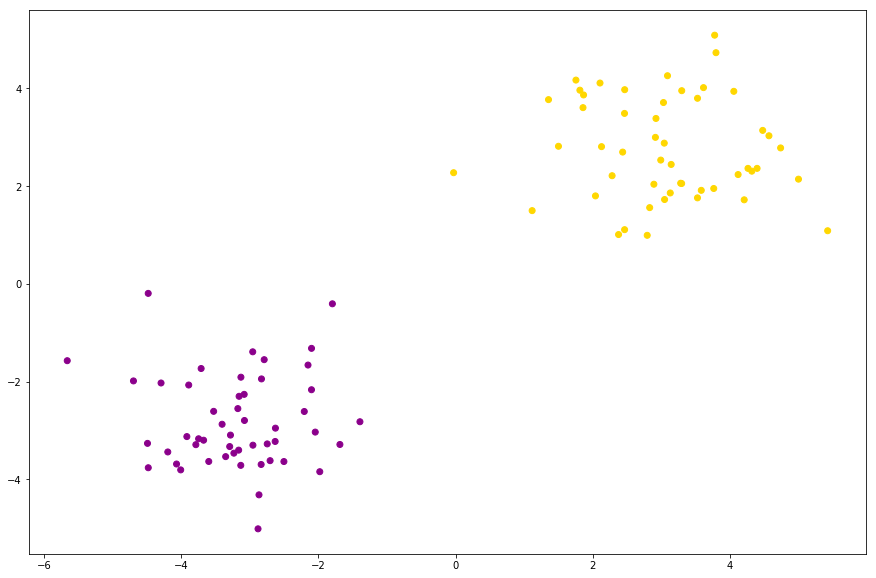

In [211]:
colors = ["darkmagenta", "gold"]
plt.figure(figsize=(15,10))
plt.scatter(X[:,0], X[:,1], c=[colors[i] for i in np.nditer(t)])
plt.show()

<div class="alert alert-info">
Make sure `laplacecomp()` works by passing it some different $w$ vectors ($w$ needs to have
dimension 2×1).</div>

In [33]:
def laplacecomp(w,X,t):
    """This function computes g and log(g) for the laplace model introduced in the lecture."""
    w = np.array(w)
    X = np.array(X)
    t = np.array(t)
    ss = 10 # Prior variance (sigma squared)
    # Evaluate log prior
    log_g = -(1/(2*ss))*w.T.dot(w)
    # Compute P
    P = 1/(1+np.exp(-X.dot(w)))
    log_l = np.sum(t*np.log(P) + (1-t)*(np.log(1-P)))
    log_g = log_g + log_l
    g = np.exp(log_g)
    return g[0][0], log_g[0][0]

In [63]:
w = np.array([[3],[4]])
laplacecomp(w, X, t)

(0.2861768385169515, -1.2511453427483288)

<div class="alert alert-info">

Implement the MH algorithm (see the flowchart in the slides). 
<br>
You might find it safest to work with $log(g)$ – the ratio then becomes a subtraction that must then be exponentiated. This has more numerical stability, especially when $w$ isn’t very good. You can start with any value of $w$. E.g., $w = randn(2,1)$. Also, use a Gaussian proposal: For example: $wp = randn(2,1)*0.5+w$ where $w$ is the current sample and $wp$ is the proposal and the Gaussian has standard deviation $0.5$ (set this as you please).
</div>

In [147]:
from numpy.random import randn, multivariate_normal, uniform

def MH(X, t, numSamples):
    
    # Init
    s = 0
    a = 0
    b = 0
    accepted = []
    
    # Random Initial Sample
    ws = randn(2,1)
    accepted.append(ws)
    
    # Loop
    while s < numSamples:
        
        # New proposal
        wp = randn(2,1) * 0.5 + ws
        
        # Generate g and log(g)
        gp, loggp = laplacecomp(wp, X, t)
        gs, loggs = laplacecomp(ws, X, t)
        
        # No correction factor needed (we chose gaussian)
        # Generate normal (p(ws-1 | X, t, sigma^2)== N(ws-1, cov))
        # pp = multivariate_normal(ws.T[0], cov)
        # ps = multivariate_normal(wp.T[0], cov)
        
        # Compute the ratio r
        r = loggp - loggs # (gp*ps)/(gs*pp)
        r = np.exp(r)
        
        # Generate u (uniform)
        u = uniform(0,1)
        
        # Acceptance
        if r >= 1 or r >= u:
            ws = wp
            accepted.append(wp)
            a += 1
        else:
            accepted.append(ws)
            b += 1
        
        s += 1
    print("Accepted:", a)
    print("Rejected:", b)
        
    return accepted

<div class="alert alert-info">
Draw samples from your MH algorithm and plot the distribution of values obtained.
</div>

In [166]:
numSamples = 10000
w_samples = MH(X,t, numSamples)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


Accepted: 8212
Rejected: 1788


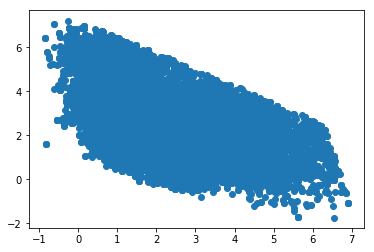

In [167]:
plt.figure()
plt.scatter([x[0][0] for x in w_samples], [x[1][0] for x in w_samples])
plt.show()

<div class="alert alert-info">
Compute the probability $P (t_{new} = 1 | x_{new} , X, t)$ when $x_{new} = [2,-4]^T$ . 
<br>
Hint – compute the probability for each value of $w$ using:
$$ \dfrac{1}{1+\exp(-w^T x_{new})} $$
</div>

In [168]:
def predict(samples, x_new):
    
    p = 0
    E = 0

    for w_s in samples:
        
        t = x_new.dot(-w_s)[0]
        z = 1/(1 + np.exp(t))
        E += z
        
    E /= len(samples)
    
    return E

In [169]:
x_new = np.array([2,-4])
predict(w_samples, x_new)

0.3159134778830779

<div class="alert alert-success">
Create a contour plot over the given range of values, while also showing the prediction for ${x_{new}}$.
</div>

In [212]:
x1min, x1max, x1step = (-6, 6.5, 0.5)
x2min, x2max, x2step = (-6, 6.5, 0.5)
x1_range = np.arange(x1min, x1max, x1step)
x2_range = np.arange(x2min, x2max, x2step)

# Compute probabilities
p = []
for x1 in x1_range:
    p_new = []
    for x2 in x2_range:
        x_new = np.array([x1,x2])
        p_new.append(predict(w_samples, x_new))
    p.append(p_new)

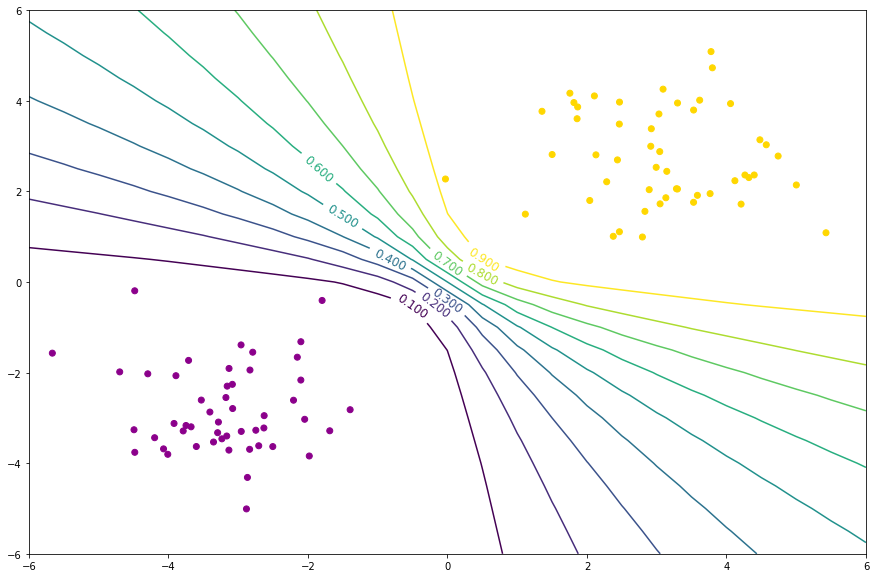

In [213]:
plt.figure(figsize=(15,10))
g = plt.contour(x1_range, x2_range, p, 10)
plt.clabel(g, inline=1, fontsize=12)
plt.scatter(X[:,0], X[:,1], c=[colors[i] for i in np.nditer(t)])
plt.show()

<div class="alert alert-success">
Comment on the plot.
</div>